In [1]:
import h5py
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
import json

%matplotlib inline

print("Test")

Test


### Load data for later use

In [2]:
FONTS = ['Skylark', 'Ubuntu Mono', 'Sweet Puppy']

file_name = "font_recognition_train_set/SynthText.h5"

db = h5py.File(file_name, "r")
im_names = list(db["data"].keys())

num_of_images = len(im_names)
print(f"Number of images: {num_of_images}")

Number of images: 760


### Use the data

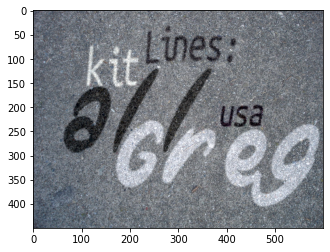

[b'usa' b'all' b'Greg' b'Lines:' b'kit']


In [3]:

i = 20 # Choose image

img_name = im_names[i]
img = db['data'][img_name][:]
font = db['data'][img_name].attrs['font']
txt = db['data'][img_name].attrs['txt']
charBB = db['data'][img_name].attrs['charBB']
wordBB = db['data'][img_name].attrs['wordBB']

plt.figure()
plt.imshow(img)
plt.show()
print(txt)

### Crop char from bounding boxes

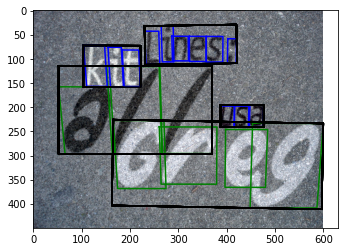

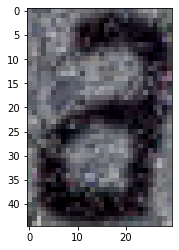

In [4]:
number_of_chars = charBB.shape[-1]

# Draw the background image (the image itself)
img_copy = img.copy()
plt.figure()
plt.imshow(img_copy)

points = []

# Draw the bounding boxes FOR THE CHARACTERS.
for char_index in range(number_of_chars):
    font_name = font[char_index].decode('UTF-8')
    if (font_name == FONTS[0]):
        color = 'r'
    elif (font_name == FONTS[1]):
        color = 'b'
    else:
        color = 'g'
    bb = charBB[:, :, char_index]
    bb_x = np.append(bb[0, :], bb[0, 0])
    bb_y = np.append(bb[1, :], bb[1, 0])
    plt.plot(bb_x, bb_y, color)

    # Last index is duplicate of first value.
    # It is done because we need to complete the rectangle (loop)
    # i.e.: 1->2, 2->3, 3->4, 4->1 (so point 1, point 2, point 3, point 4, point 1 to complete the loop)

    # Draw the bounding boxes FOR THE WORDS.
    number_of_words = wordBB.shape[-1]
    for word_index in range(number_of_words):
        bb = wordBB[:, :, word_index]
        x = np.append(bb[0, :], bb[0, 0])
        y = np.append(bb[1, :], bb[1, 0])
        #print(f"Word {word_index} bb_x: {x} bb_y: {y}")
        plt.plot(x, y, 'k')

    x = bb_x[:4]
    y = bb_y[:4]
    points.append((x,y))

assert number_of_chars == len(points)



cropped_char_imgs = []


for point in points:
    x,y = point
    x_min, y_min, x_max, y_max = np.min(x).astype(np.int32), np.min(y).astype(np.int32), np.max(x).astype(np.int32), np.max(y).astype(np.int32)
    cropped = img[y_min:y_max, x_min:x_max]
    cropped_char_imgs.append(cropped)
    

cropped = cropped_char_imgs[2]
plt.figure()
plt.imshow(cropped)



### Binary thresholding

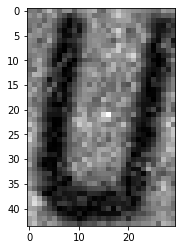

Mean: 81.91439393939395 , Average: 81.91439393939395


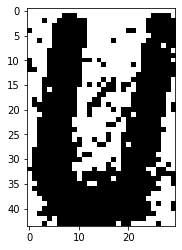

'\ndetector = cv2.SimpleBlobDetector()\nkeypoints = detector.detect(im)\nim_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\ncv2.imshow("Keypoints", im_with_keypoints)\n'

In [5]:
i = 0
img = cropped_char_imgs[i]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(gray, interpolation="none", cmap="gray")
plt.show()

gray_copy = gray.copy()
print(f"Mean: {np.mean(gray)} , Average: {np.average(gray)}")
for y in range(gray_copy.shape[0]):
    for x in range(gray_copy.shape[1]):
        if(gray[y, x] > np.mean(gray)):
            gray[y, x] = 255
        else:
            gray[y, x] = 0

gray = [x / 255.0 for x in gray]



plt.figure()
plt.imshow(gray, interpolation="none", cmap="gray")
plt.show()
"""
detector = cv2.SimpleBlobDetector()
keypoints = detector.detect(im)
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("Keypoints", im_with_keypoints)
"""

### Save entire database to useable json

In [21]:

def extract_data(img_name):
    """
    Process the image and returned processed result.
    Return a json in the following structure (as an example):
    
    {
        "img": <ndarray>
        "name": "test.png",
        "words": [
            {
                "word": "the",
                "font": "Ubuntu Mono",
                "chars": [
                    {
                        "char": "t",
                        "font": "Ubuntu Mono"
                        "bb": <ndarray>
                    }, ...
                ],
                "bb": <ndarray>
            },
            {
                "word": "shlomi",
                "font": "Skylark",
                "chars": [
                    {
                        "char": "s",
                        "font": "Skylark",
                        "bb": <ndarray>
                    }, ...
                ],
                "bb": <ndarray>
            }, ...
        ]
    }
    """
    img = db['data'][img_name][:]
    font = db['data'][img_name].attrs['font']
    txt = db['data'][img_name].attrs['txt']
    charBB = db['data'][img_name].attrs['charBB'] # Contains list of bb for words.
    wordBB = db['data'][img_name].attrs['wordBB'] # Contain list of bb for chars.


    words = []
    char_index_accumulator = 0
    word_index = 0
    for word in txt:
        word_font = font[char_index_accumulator].decode()
        chars = []
        
        # Draw the bounding boxes FOR THE WORDS.
        word_bb = wordBB[:, :, word_index]
        x = np.append(word_bb[0, :], word_bb[0, 0])
        y = np.append(word_bb[1, :], word_bb[1, 0])
        plt.plot(x, y, 'r', ) #red color

        # Process chars
        for char_index in range(len(word)):
            char = chr(word[char_index])
            char_font = font[char_index_accumulator].decode()
            bb = charBB[:, :, char_index_accumulator]
            
            assert char_font == word_font # Double check that the pre-processed image is indeed 1 font per word, and each char is same font as word.
            
            # Append char json
            chars.append({
                "char": char,
                "font": char_font,
                "bb": bb
            })
            
            char_index_accumulator += 1
            
            x = np.append(bb[0, :], bb[0, 0])
            y = np.append(bb[1, :], bb[1, 0])
            plt.plot(x, y, 'k')
            
            
        # Append word json
        words.append({
            "word": word.decode(),
            "font": word_font,
            "chars": chars,
            "bb": wordBB
        })
        word_index += 1
    
    # Return result
    return {
        "image": img,
        "name": img_name,
        "words": words,
    }


### Example how to use the json

would
Font: Ubuntu Mono
First char: w


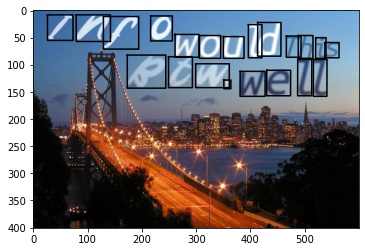

In [22]:

img_name = im_names[50]
img = db['data'][img_name][:]
plt.figure()
plt.imshow(img)

res = extract_data(img_name)


print(res["words"][0]["word"])
print("Font:", res["words"][0]["font"])
print("First char: " + str(res["words"][0]["chars"][0]["char"]))

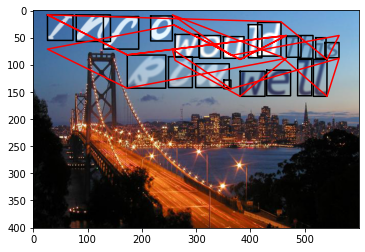

In [20]:
img_name = im_names[50]
img = db['data'][img_name][:]
plt.figure()
plt.imshow(img)

res = extract_data(img_name)

word = res["words"][0]
bb = word["bb"]

x = np.append(bb[0, :], bb[0, 0])
y = np.append(bb[1, :], bb[1, 0])
plt.plot(x, y, 'r', ) #red color